# **GeolifePrj_02_extrafeatures.ipynb**
## Usamos los archivos pickle **geolife_xxx.zip** del Notebook **GeolifePrj_00_plt2df.ipynb** y agregamos algunas features (="properties" en geojson) y creamos **geolife_xxx_features.geojson** para una mejor visualización
## Guardamos como intermediario archivo **geolife_xxx_features.zip**

#### Algunos imports

In [319]:
import geopandas
import numpy as np
import pandas as pd
#from shapely.geometry import Point
from geojson import  Point,Feature, FeatureCollection, dumps
from datetime import timedelta, datetime
import csv, json

import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

from collections import OrderedDict

from shapely.geometry import LineString
from shapely.geometry import Point

from dateutil.parser import parse as parsedt

#### constantes para tagear los puntos geojson y crear colores

In [168]:
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 
              'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_marker = ['pitch', 'bicycle', 'bus', "car", 'rail-underground','rail', 
              'airport', 'ferry', 'pitch', 'scooter', 'car']
mode_color = ['#f16f04', '#1ac16b', '#68aa31', '#8043b1', '#29c6db','#470e53', 
              '#595454', '#2026d5', '#f16f04', '#e52315', '#f6fa00']

mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
mode_marker_dict = {i + 1:s for i, s in enumerate(mode_marker)}
mode_color_dict = {i + 1:s for i, s in enumerate(mode_color)}

cmaps = {}
cmaps['Uniform'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis','spring','summer','autumn','winter']
cmaps['Diverging'] = [ 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']
cmaps['Miscellaneous'] = [ 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

cmap = plt.get_cmap(cmaps['Uniform'][0])
colors.to_hex(cmap(255))

'#fde725'

#### Probamos ver a que corresponde el valor **label**=4 (=modo de transporte)

In [323]:
label = 4
mode_names[label-1], mode_marker_dict[label] , mode_color_dict[label]

('car', 'car', '#8043b1')

## def **read_df_add_features(**archivo_pickle**)**:
### Devuelve: DataFrame
### Carga DataFrame **df** ("geolife_xxx.zip") y agrega features : 
### *Features:* **'vel'** : velocidad aproximada , **velprep** : velocidad preprocesada para eliminar picos , **'velMA'** : velocidad suavizada con Moving Average ( df.col.rolling(...).mean() )
### 'velprep' , 'velprep2' , 'velprep3' , 'pruebas' , 'velMA2' y 'velMA3' son postprocesamientos de 'velprep' para tratar de deducir el modo de transporte


In [420]:
#agrega columna de velocidad 'vel' , 'velMA' y velMA2
def read_df_add_features(pickle_file , vel='vel', lat='lat',lon='lon',time='time'):
    df = pd.read_pickle(pickle_file)

    df['idx_traj'] = df.index
    df.idx_traj=df.idx_traj.apply(int)
    df.reset_index(inplace=True,drop=True)
    df[vel]=0
    vel_ix = df.columns.get_loc(vel)
    lat_ix = df.columns.get_loc(lat)
    lon_ix = df.columns.get_loc(lon)
    time_ix = df.columns.get_loc(time)
    factor_r2m=111139*3.6 # gps/t  ->  km/h  // 111139 -> m/s
    lp=100/len(df)
    print("")
    for i in range(1,len(df)):        
        print( f"Calculando velocidades: {(i*lp):.2f}%  ",end="\r")
        d=factor_r2m*((df.iloc[i,lon_ix]-df.iloc[i-1,lon_ix])**2+(df.iloc[i,lat_ix]-df.iloc[i-1,lat_ix])**2)**0.5  #pythagoras entre row(i) y row(i-1=)
        t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds+0.01
        df.iloc[i,vel_ix]=d/t
        """ t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds
        if t==0:
            df.iloc[i,vel_ix]=0
        else:
            df.iloc[i,vel_ix]=np.float(d/t)
            """ 
        
        
    df.iloc[0,vel_ix]=df.vel.iloc[1]
    df.vel=df.vel.apply(lambda x:round(x,2))    
    
    #FEATURES A BASE
    df['velMA']= df[vel].rolling(30, win_type='triang',min_periods=1, center=True).mean()
    clip1 = df.velMA.max()
    media = df.velMA.mean()
    print(f"clip: {clip1}",end=" ")
    df['velprep']=df.vel.apply(lambda x : x if x<clip1 else media )    
    df['velMA']= df['velprep'].rolling(15, win_type='triang',min_periods=1, center=True).mean()
    df['velMA2']= df['velprep'].rolling(45, win_type='hamming',min_periods=1,center=True).mean()          
    df['velMA3']= df['velprep'].rolling(250, win_type='hamming',min_periods=1,center=True).mean() 
    
    df['velprep2']=df.velMA3.apply(lambda x : 5+(15*np.round((x+1)/15)))
    df['pruebas']= df['velprep2'].rolling(450, win_type='hamming',min_periods=1,center=True).mean() 
    df['vel_label']=df.pruebas.apply(lambda x : 2+(30*np.round((x)/30)))   
    
    return df


## def **read_df_add_features_fast(**archivo_pickle**)**:
### Lo mismo que **read_df_add_features(**archivo**)** pero más rápido y con lo indispensable, version produccion

In [421]:
from math import sqrt
#agrega columna de velocidad 'vel' , 'velMA' y velMA2
def read_df_add_features_fast(pickle_file , vel='vel', lat='lat',lon='lon',time='time'):
    df = pd.read_pickle(pickle_file)
    
    df['idx_traj'] = df.index
    df.idx_traj=df.idx_traj.apply(int)
    df.reset_index(inplace=True,drop=True)
    df[vel]=0
    vel_ix = df.columns.get_loc(vel)
    lat_ix = df.columns.get_loc(lat)
    lon_ix = df.columns.get_loc(lon)
    time_ix = df.columns.get_loc(time)
    factor_r2m=111139*3.6 # gps/t  ->  km/h  // 111139 -> m/s
    lp=100/len(df)    
    print("")
    for i in range(1,len(df)):
        print( f"Calculando velocidades: {(i*lp):.2f}%  ",end="\r")
        d=factor_r2m*sqrt(((df.iloc[i,lon_ix]-df.iloc[i-1,lon_ix])**2+(df.iloc[i,lat_ix]-df.iloc[i-1,lat_ix])**2)) #pythagoras entre row(i) y row(i-1=)
        t=(df.iloc[i,time_ix]-df.iloc[i-1,time_ix]).seconds+0.01
        #if t==0:
        #    df.iloc[i,vel_ix]=0
        #else:
        df.iloc[i,vel_ix]=d/t
            
    df.iloc[0,vel_ix]=df.vel.iloc[1]
    
    #FEATURES A BASE
    df['velMA']= df[vel].rolling(30, win_type='triang',min_periods=1, center=True).mean()
    clip1 = df.velMA.max()
    media = df.velMA.mean()
    print(f"clip: {clip1}",end=" ")
    df['velprep']=df.vel.apply(lambda x : x if x<clip1 else media )            
    df['velMA3']= df['velprep'].rolling(250, win_type='hamming',min_periods=1,center=True).mean()     
    df['velprep']=df.velMA3.apply(lambda x : 5+(15*np.round((x+1)/15)))
    
    return df


In [352]:
Python statistics | mode function
Python - Power-Function Distribution in Statistics
Python statistics | median_high()
Python statistics | median()
Python statistics | harmonic_mean()
Python statistics | median_low()
Python statistics | pvariance()
Python statistics | median_grouped()
Python statistics | variance()
Python statistics | stdev()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [367]:
dfs= df.vel.rolling(30, win_type='triang',min_periods=1, center=True).mean()
clip1 = dfs.max()
media = dfs.mean()
modes=df.vel.mode()
med=df.vel.median()

print(clip1,media,modes,med)

95.01928888888891 23.286849652735214 0    14.91
dtype: float64 19.564999999999998


In [375]:
df.vel.max()

1010.34

In [416]:
timedelta(microseconds=1).seconds

0

## def **plot_evolucion_vel(**df , start_dt, end_dt,...):
### Plotea la evolución de la columna 'vel' y varias estadísticas más a partir de un **DataFrame** df ( DataFrame creado con **df=read_df_add_features(pickle_file,...)** )

In [372]:
def plot_evolucion_vel( df,start_dt , end_dt , vel='vel', tit="Evolucion de velocidad"):
    #muestra velocidad a través del tiempo
    if not isinstance(start_dt, datetime):
        start_dt = parsedt(start_dt)
    if not isinstance(end_dt, datetime):
        end_dt = parsedt(end_dt)
    
    f=plt.figure(figsize=(20,10))
    plt.xlabel(f'TIEMPO: del  {start_dt}  al  {end_dt}', fontsize=16)
    plt.ylabel('VELOCIDAD [km/h]', fontsize=16)
    df = df.loc[(df.time > start_dt) & (df.time < end_dt)]
    if(len(df)==0):
        f.suptitle("No hay datos en este rango de fechas!", fontsize=26)
    else:
        f.suptitle(tit, fontsize=26)
        

    #rangotiks=df.velMA.nlargest(20).index.values.tolist()
    #rangotiks.extend(df.velMA.nsmallest(20).index.values.tolist())
    rangotiks=range(df.index[0],df.index[len(df)-1],round(len(df)/20+1))
    print(rangotiks)
    print(df.index[0],df.index[len(df)-1])
    rangolabels = list(df.loc[df.index.isin(rangotiks), 'time'])
    plt.xticks(ticks=rangotiks, labels=rangolabels,  rotation=90)
    
    plt.plot(df[vel] , 'b')
    plt.plot(df.velMA, 'ro') 
    plt.plot(df.velMA2, 'g')     
    plt.plot(df.velMA3, 'y')     
    plt.plot(df.pruebas, 'k')      
    plt.plot(df.vel_label, 'c') 
    
    
    #plt.axvline(x=100)
    #plt.axvline(x=0.33088437)
    #plt.axvline(x=2.20589566)


## Cargamos archivo=**geolife_xxx.zip** , le agregamos features df=**read_df_add_features(archivo,...)** y finalmente hacemos 
## df**.to_pickle("geolife_xxx_features.zip")**

In [ ]:
%%time
#solo se cambia este numero

x_x=[0,1,52,111,113]
xxx=x_x[0]
for xxx in [a  for a in range(4,182) if a not in x_x]:
    archivo=f"geolife_{xxx:03d}.zip"
    archivo_salida=archivo[:-4]+"_features.zip"
    print(f"Cargando y procesando {archivo} / ",end="")
    df=read_df_add_features(archivo)
    #df=read_df_add_features(archivo)
    print(f"Guardando a {archivo_salida} ")
    df.to_pickle(archivo_salida)
df

Cargando y procesando geolife_004.zip / 


In [424]:
start_ix=df.loc[df.idx_traj==0].index.tolist()
end_ix = [ i-1 for i in start_ix[1:]]
end_ix.append(len(df)-1)
print(start_ix,"\n",end_ix)

[0, 154, 1263, 3165, 3267, 4742, 6589, 8270, 10322, 10906, 13601, 14269, 14372, 16857, 16975, 17426, 17528, 18366, 18518, 19304, 22297, 22435, 25955, 30632, 31227, 36418, 36521, 37084, 37221, 38332, 38475, 39730, 39857, 42607, 42878, 44398, 45762, 45965, 47608, 47760, 47849, 48329, 50151, 50236, 51715, 54078, 61346, 62257, 66776, 67562, 67794, 76039, 79589, 79700, 79714, 81416, 85858, 86594, 86742, 88225, 92286, 95031, 95034, 99665, 100199, 102143, 108576, 109782, 115081, 115095, 118166, 121276, 124241, 124653, 127299, 129164, 133444, 133678, 133801, 135620, 136829, 140112, 141362, 141437, 144171, 144175, 146168, 146187, 146291, 149244, 152553, 152589, 157578, 158319, 158640, 159264, 159417, 159566, 163158, 165125, 165201, 165672, 166261, 168806, 172303, 172383, 172901, 173437, 173776, 174021, 174477, 174568, 178547, 179643, 179739, 182407, 193487, 194240, 195656, 197747, 204624, 206028, 208921, 210661, 213004, 213760, 214680, 215886, 216734, 223986, 224520, 225042, 225636, 225815, 226

#### Mostramos una pequeña estadística antes de comenzar (se ve que la mayor parte del tiempo se mueve lento o no se mueve)

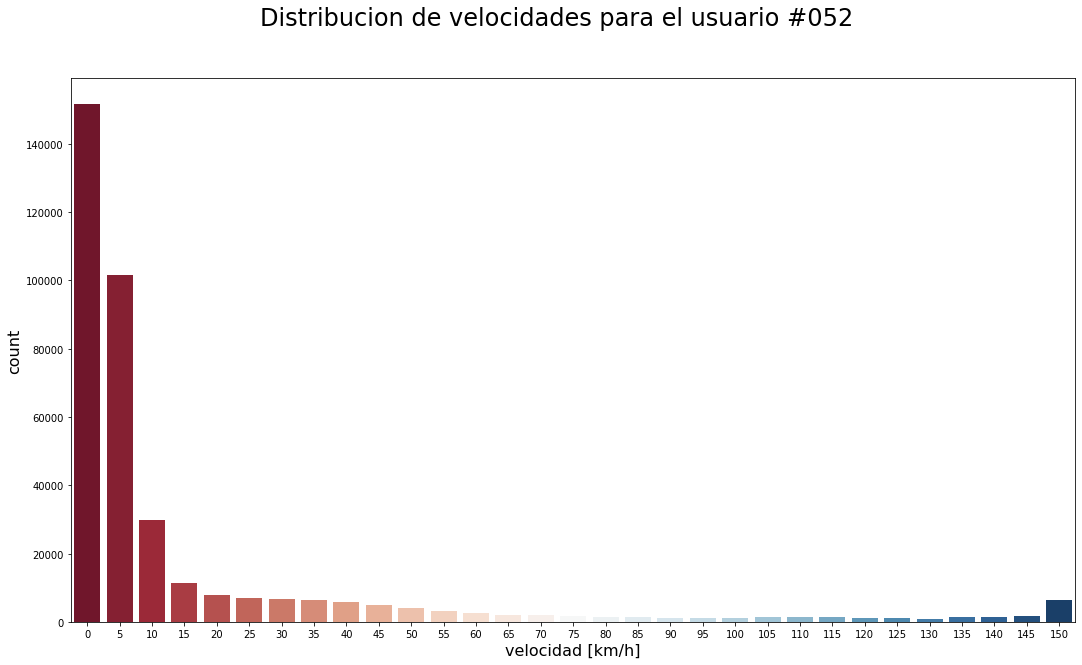

In [398]:
l=[e if e<150 else 150 for e in list(df.vel.apply(lambda x:5*round(x/5))) ]

f=plt.figure(figsize=(18,10))
f.suptitle(f'Distribucion de velocidades para el usuario #{df.user[0]:03d}', fontsize=24)
plt.xlabel('velocidad [km/h]', fontsize=16)
plt.ylabel('features', fontsize=16)
#ax.set_title("Distribucion de velocidades [km/h]", fontsize=14)
sns.countplot(l , palette="RdBu")

### Calcula inicio y fin de trayectorias (cada trayectoria equivale a la data de un solo archivo .plt original)

In [369]:
start_ix=df.loc[df.idx_traj==0].index.tolist()
end_ix = [ i-1 for i in start_ix[1:]]
end_ix.append(len(df)-1)
print("Indices de inicio y fin de cada trayectoria")
print("Inicio: ",start_ix,"\nFin:",end_ix)
for i in range(len(start_ix)):
    s_str=df.loc[start_ix[i],'time']
    e_str=df.loc[end_ix[i],'time']
    print("Trayectoria:",i,":",s_str," <--> ",e_str)

Indices de inicio y fin de cada trayectoria
Inicio:  [0, 30, 107, 1436, 1460, 1498, 1511, 1530, 1607, 1613, 1757, 1866, 1891, 1938, 1959, 2587, 2608, 2622, 3431, 3462, 4478, 4646, 4939, 4954, 4966, 4974, 4980, 4989, 5047, 5393, 5447, 5511, 5569, 6494, 6861, 7303, 7715, 8636, 9379, 10290, 11327, 12119, 12933, 14527] 
Fin: [29, 106, 1435, 1459, 1497, 1510, 1529, 1606, 1612, 1756, 1865, 1890, 1937, 1958, 2586, 2607, 2621, 3430, 3461, 4477, 4645, 4938, 4953, 4965, 4973, 4979, 4988, 5046, 5392, 5446, 5510, 5568, 6493, 6860, 7302, 7714, 8635, 9378, 10289, 11326, 12118, 12932, 14526, 15325]
Trayectoria: 0 : 2007-04-13 15:23:30  <-->  2007-04-13 15:42:54
Trayectoria: 1 : 2007-04-14 03:36:16  <-->  2007-04-14 03:57:02
Trayectoria: 2 : 2007-04-15 00:49:23  <-->  2007-04-15 09:06:57
Trayectoria: 3 : 2007-04-15 10:44:58  <-->  2007-04-15 11:03:10
Trayectoria: 4 : 2007-04-16 14:44:10  <-->  2007-04-16 15:13:37
Trayectoria: 5 : 2007-04-17 02:07:24  <-->  2007-04-17 02:14:52
Trayectoria: 6 : 2007-04-

# Plot Evolucion de velocidades por trayectorias

2009-09-23 09:20:00  <-->  2009-09-23 09:21:10
range(1, 13, 2)
1 13
2009-09-23 15:43:35  <-->  2009-09-23 22:04:18
range(16, 3089, 155)
16 3089
2009-09-24 18:30:29  <-->  2009-09-24 23:19:54
range(3092, 5249, 109)
3092 5249
2009-09-26 19:09:29  <-->  2009-09-26 22:52:17
range(5252, 7272, 102)
5252 7272
2009-09-27 08:33:34  <-->  2009-09-27 16:12:13
range(7275, 8826, 79)
7275 8826


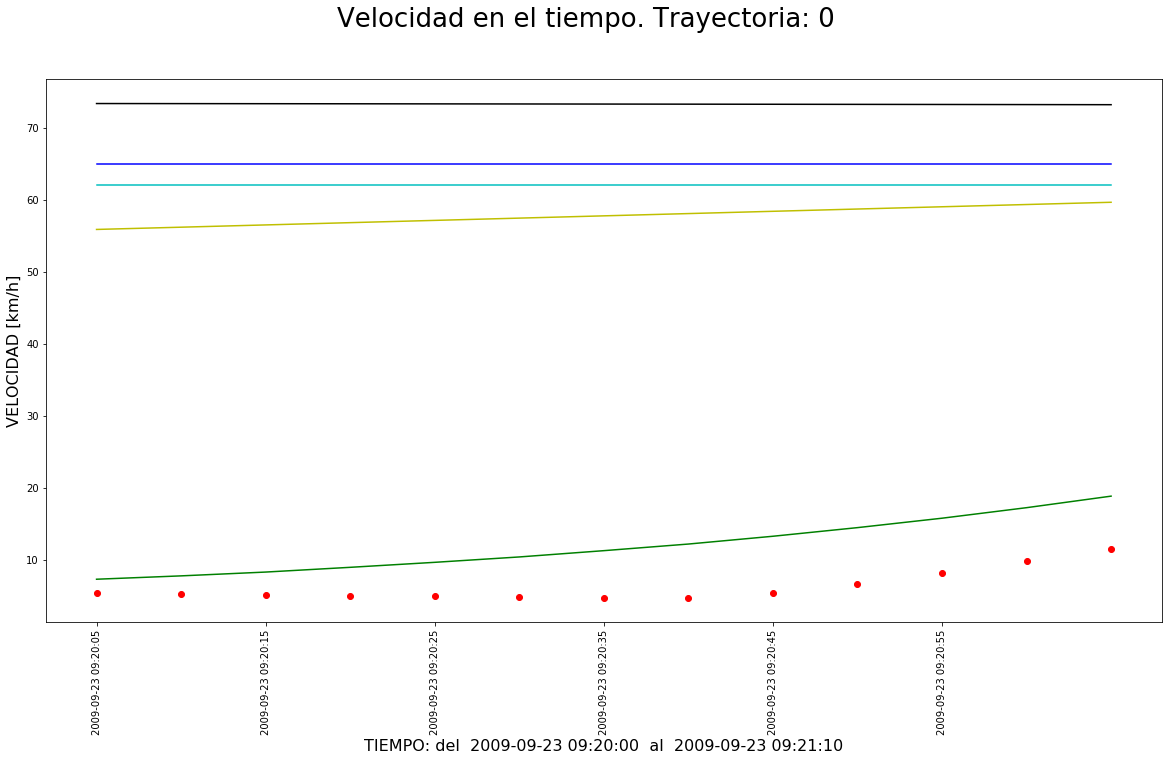

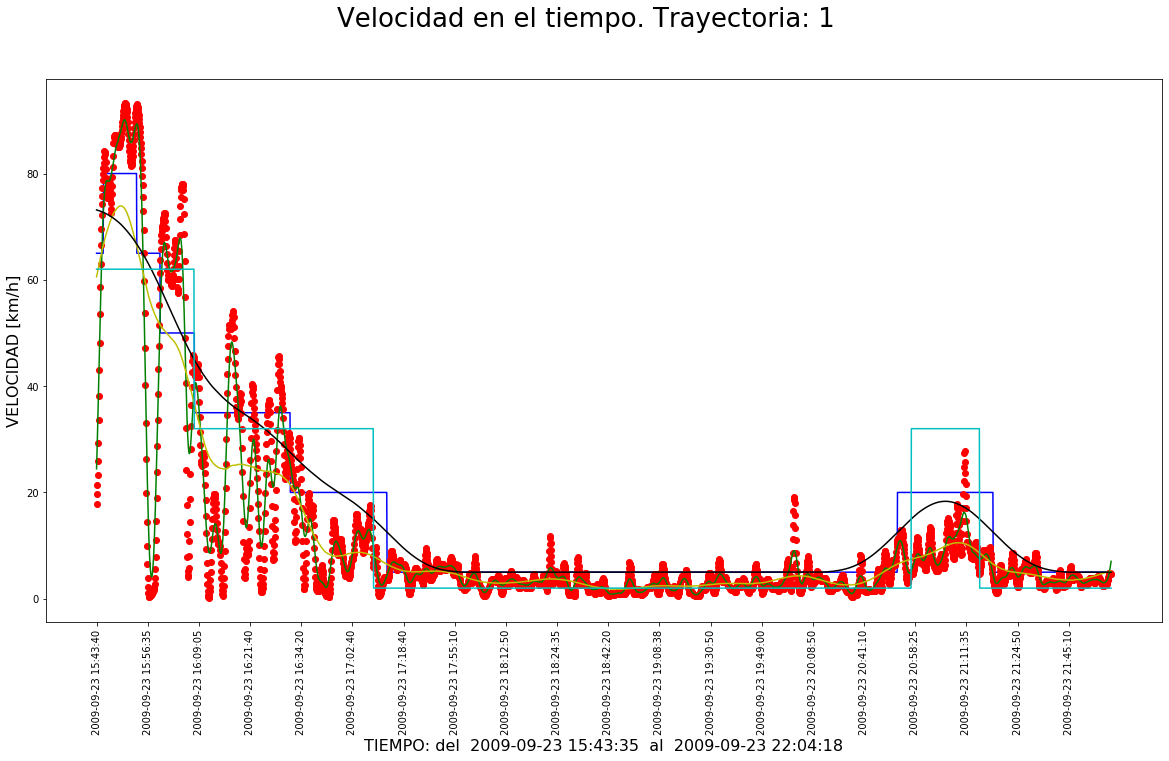

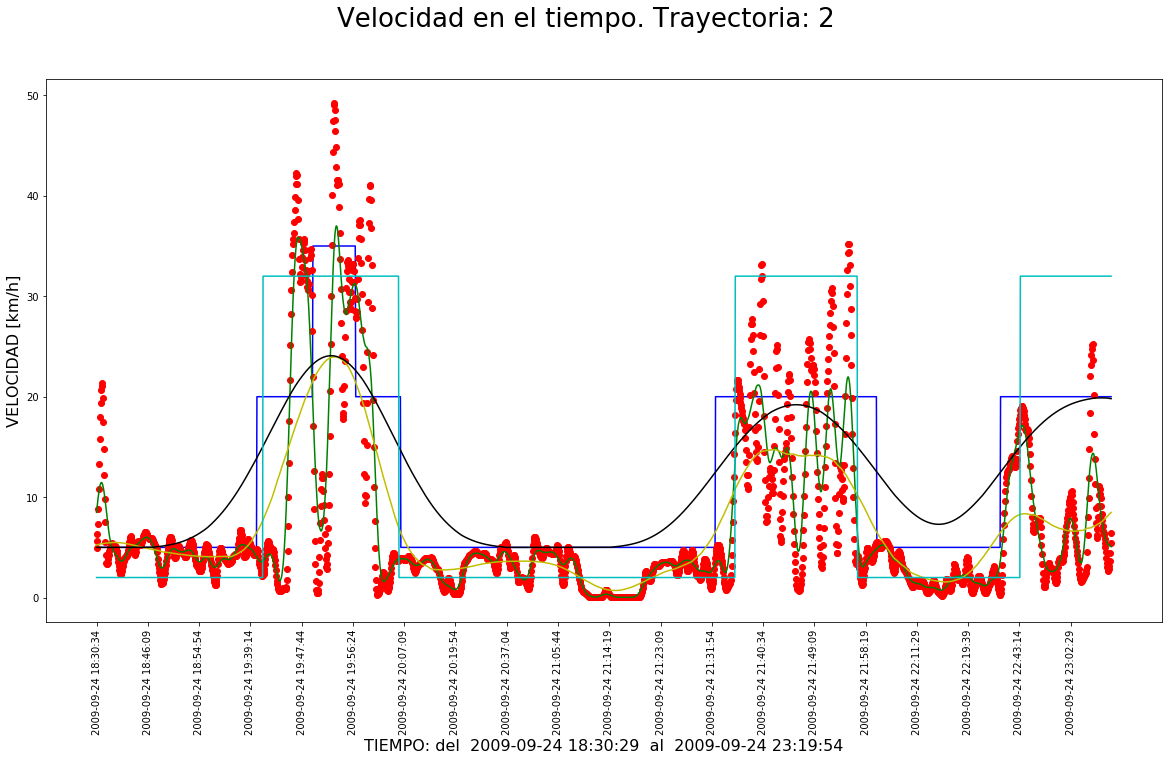

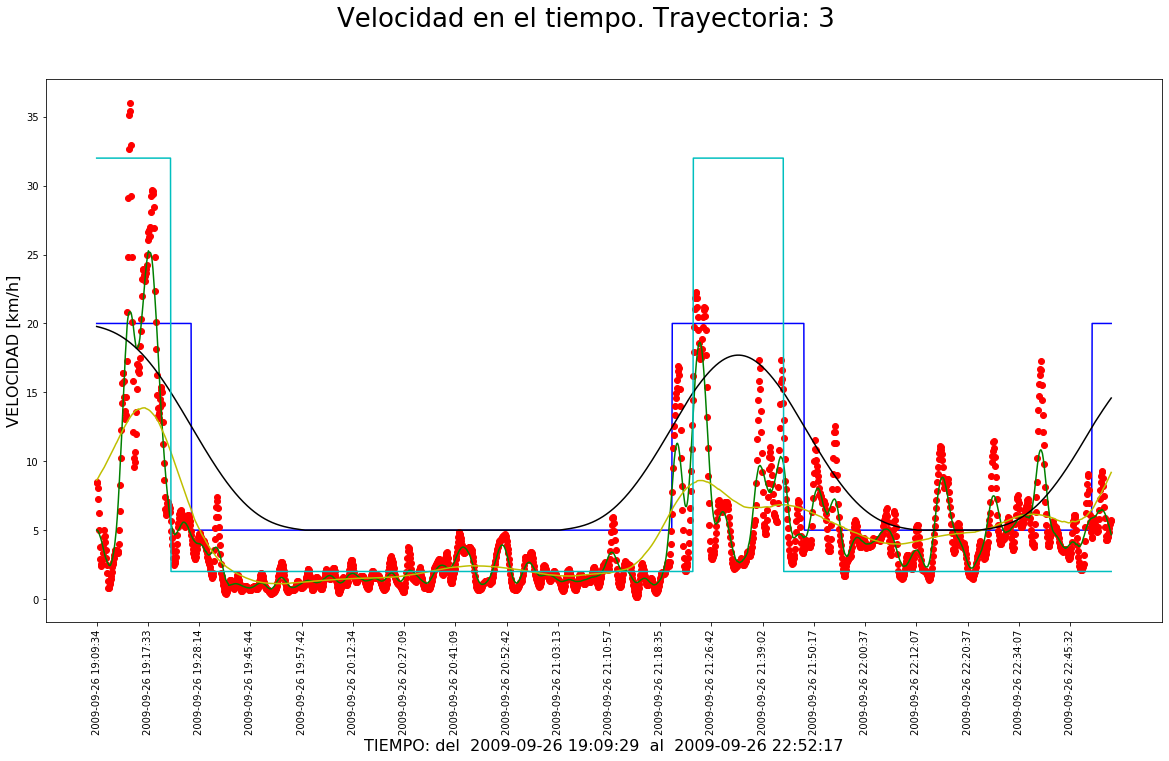

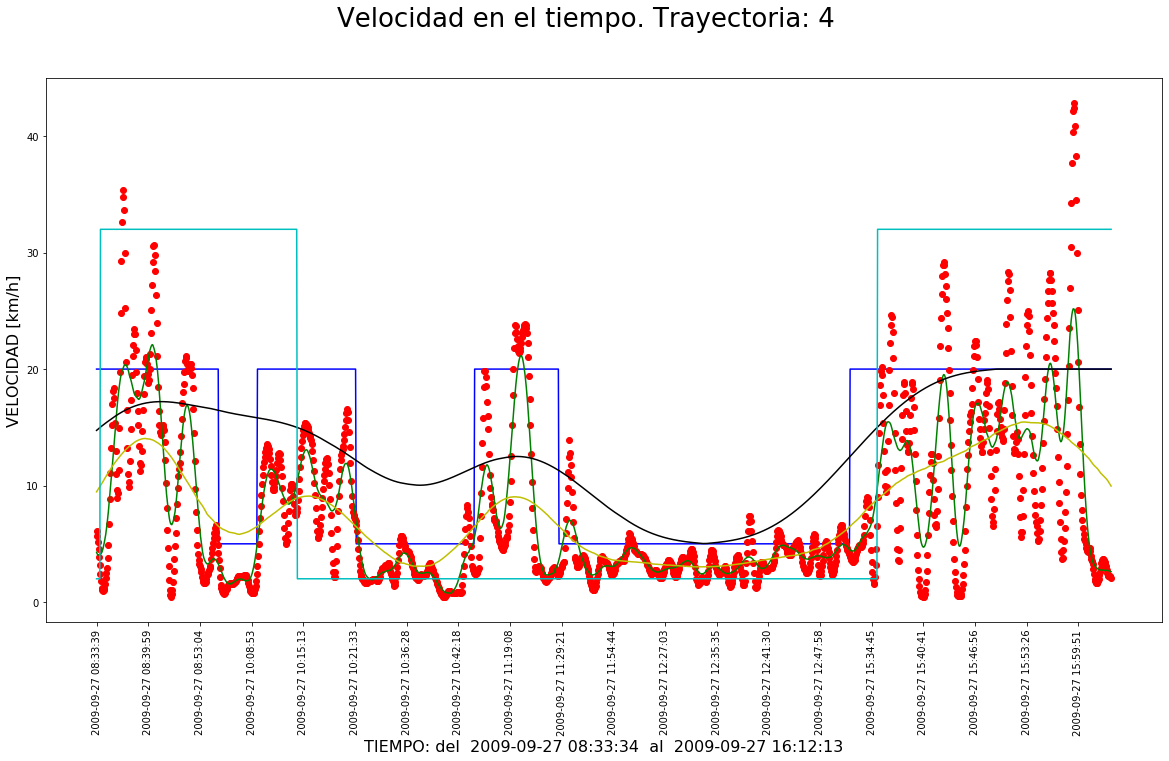

In [315]:

for trayectoria,rangodt in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) ] : #if idx<24
    s_str=df.loc[rangodt[0],'time']
    e_str=df.loc[rangodt[1],'time']
    print(s_str," <--> ",e_str)
    plot_evolucion_vel(df,s_str,e_str, vel='velprep2' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")


In [253]:
print(df.loc[0,'time']," ",df.loc[len(df)-1,'time'])

2009-09-23 09:20:00   2009-09-27 16:12:13


2007-04-19 00:36:25  <-->  2007-04-19 01:47:38
range(1758, 1864, 6)
1758 1864
2007-04-19 13:18:53  <-->  2007-04-19 14:04:28
range(1867, 1889, 2)
1867 1889
2007-04-20 01:02:23  <-->  2007-04-20 01:29:01
range(1892, 1936, 3)
1892 1936
2007-04-20 07:56:32  <-->  2007-04-20 08:36:01
range(1939, 1957, 2)
1939 1957
2007-04-21 01:14:19  <-->  2007-04-21 11:28:13
range(1960, 2585, 32)
1960 2585
2007-04-23 14:21:22  <-->  2007-04-23 14:32:36
range(2588, 2606, 2)
2588 2606
2007-04-27 06:10:46  <-->  2007-04-27 06:16:18
range(2609, 2620, 2)
2609 2620
2007-06-08 23:20:55  <-->  2007-06-09 06:34:31
range(2623, 3429, 41)
2623 3429
2007-06-10 09:46:24  <-->  2007-06-10 10:04:41
range(3432, 3460, 2)
3432 3460


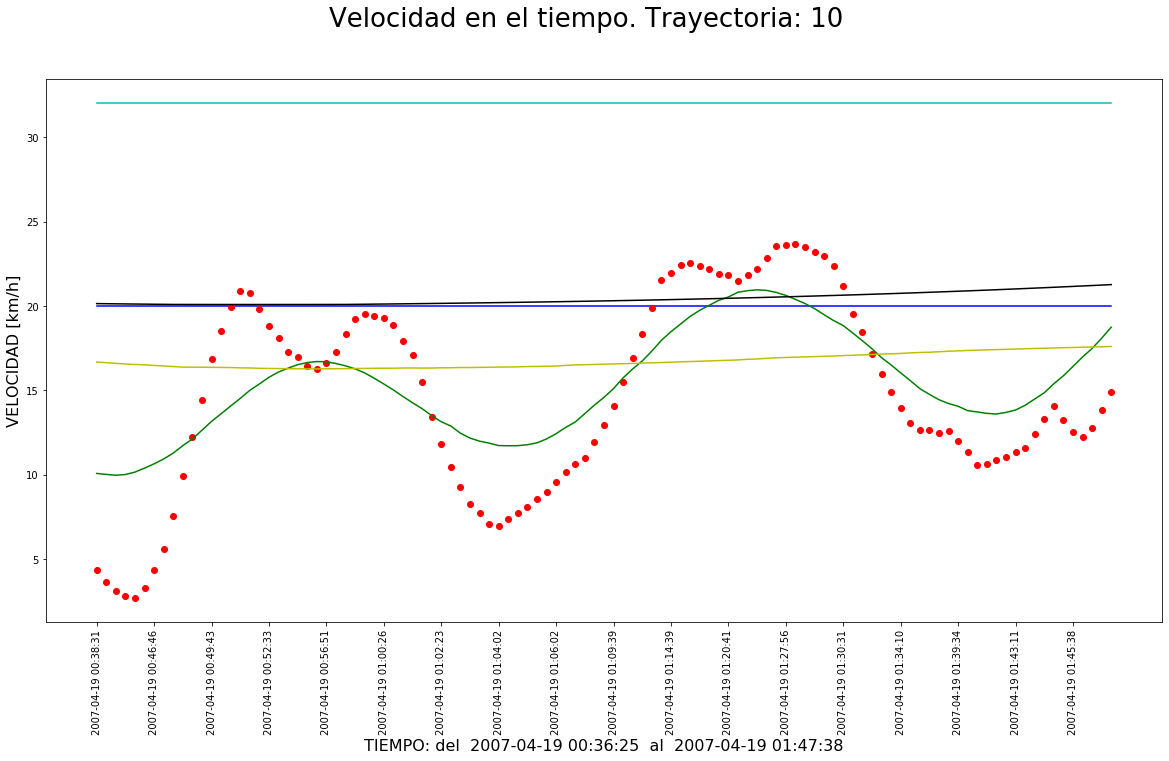

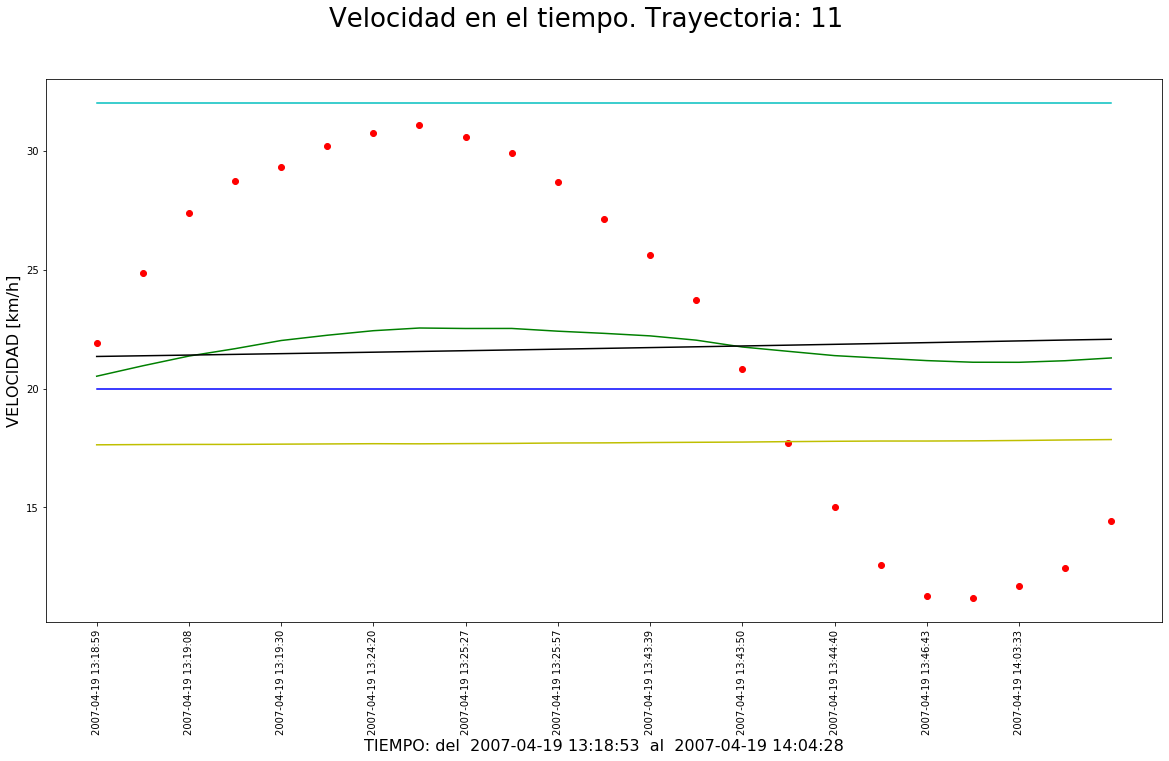

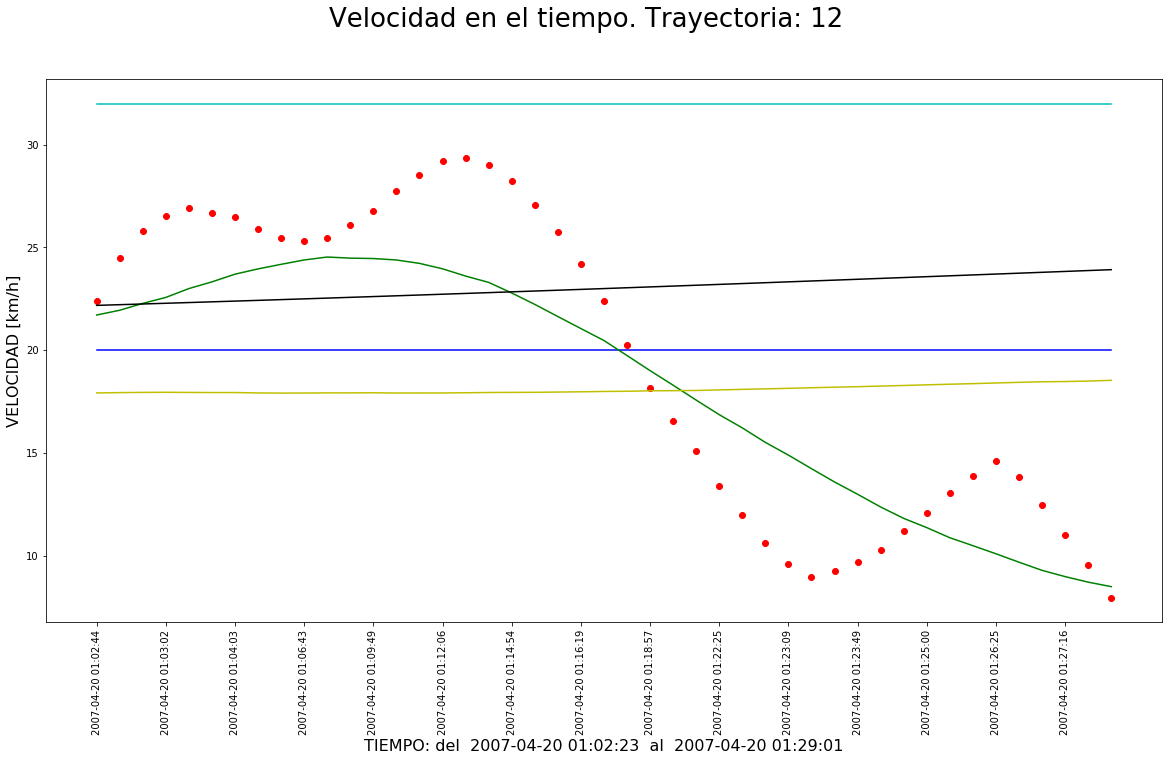

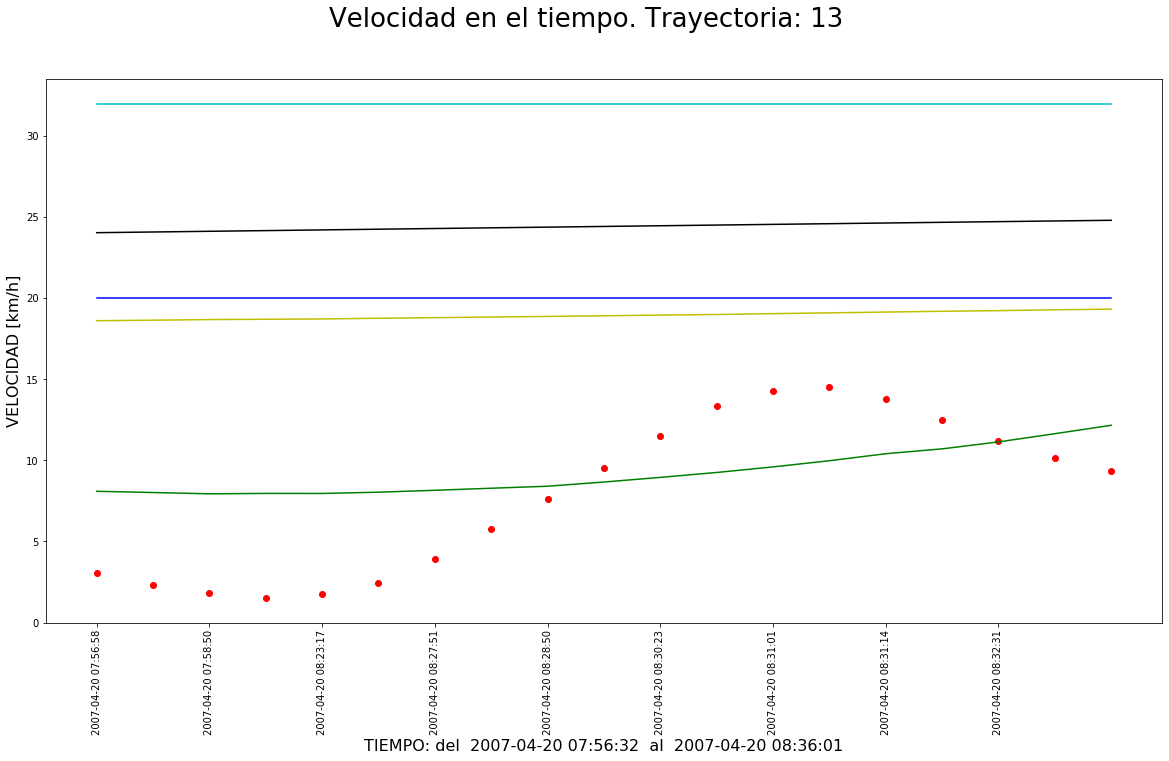

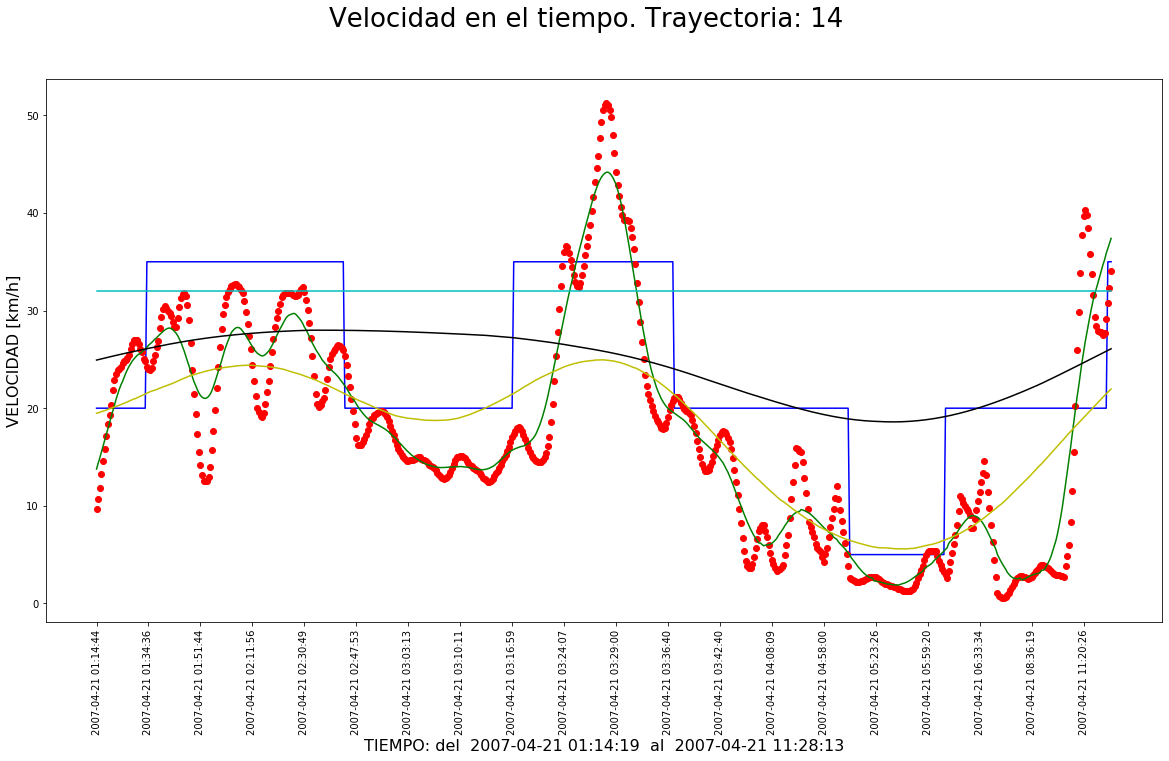

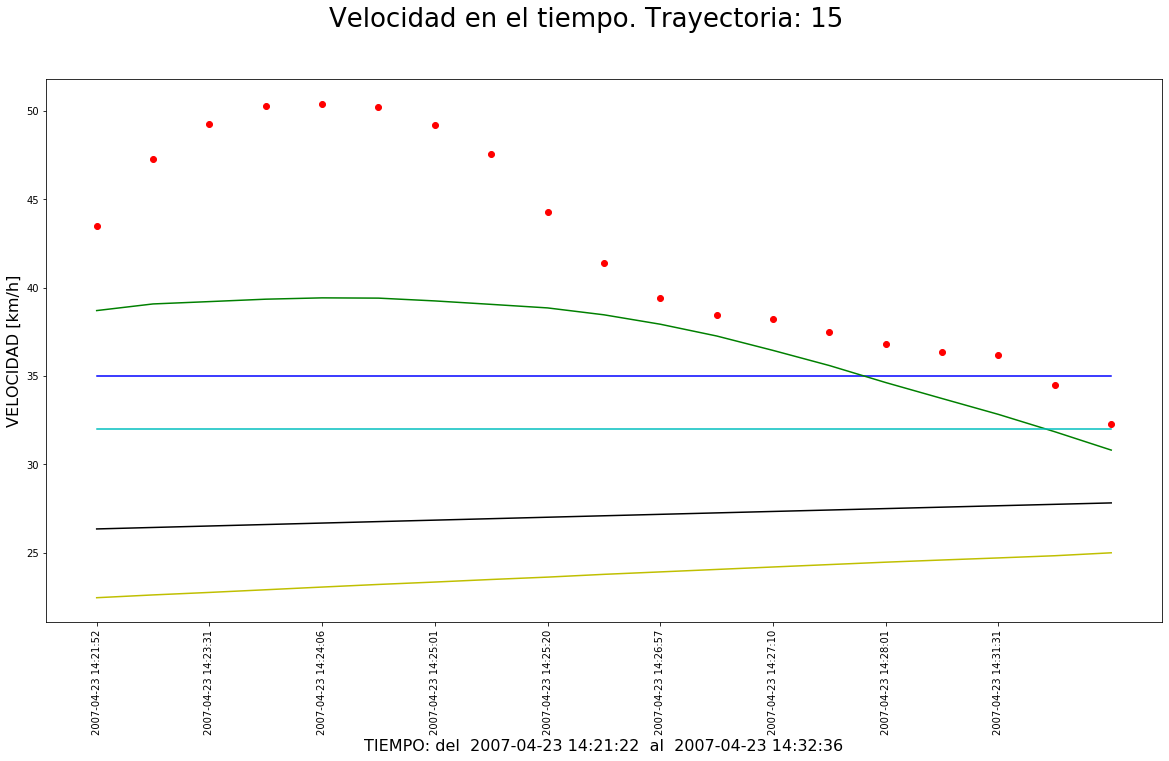

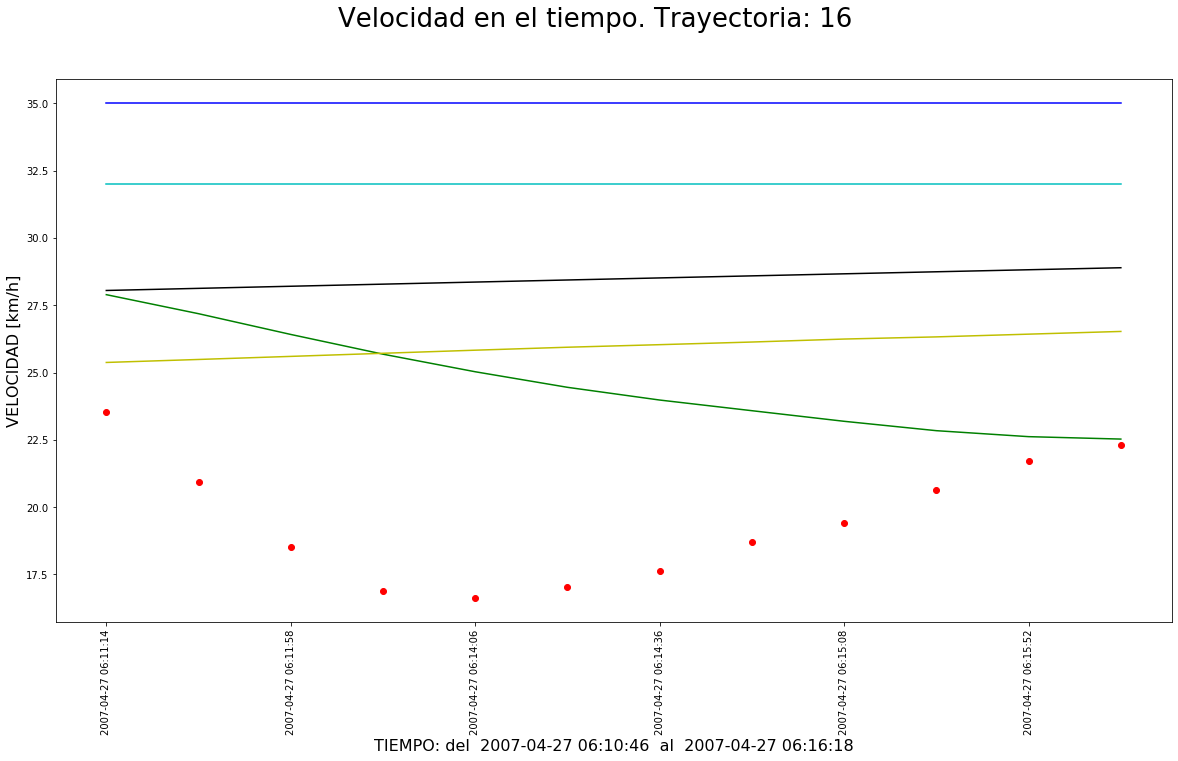

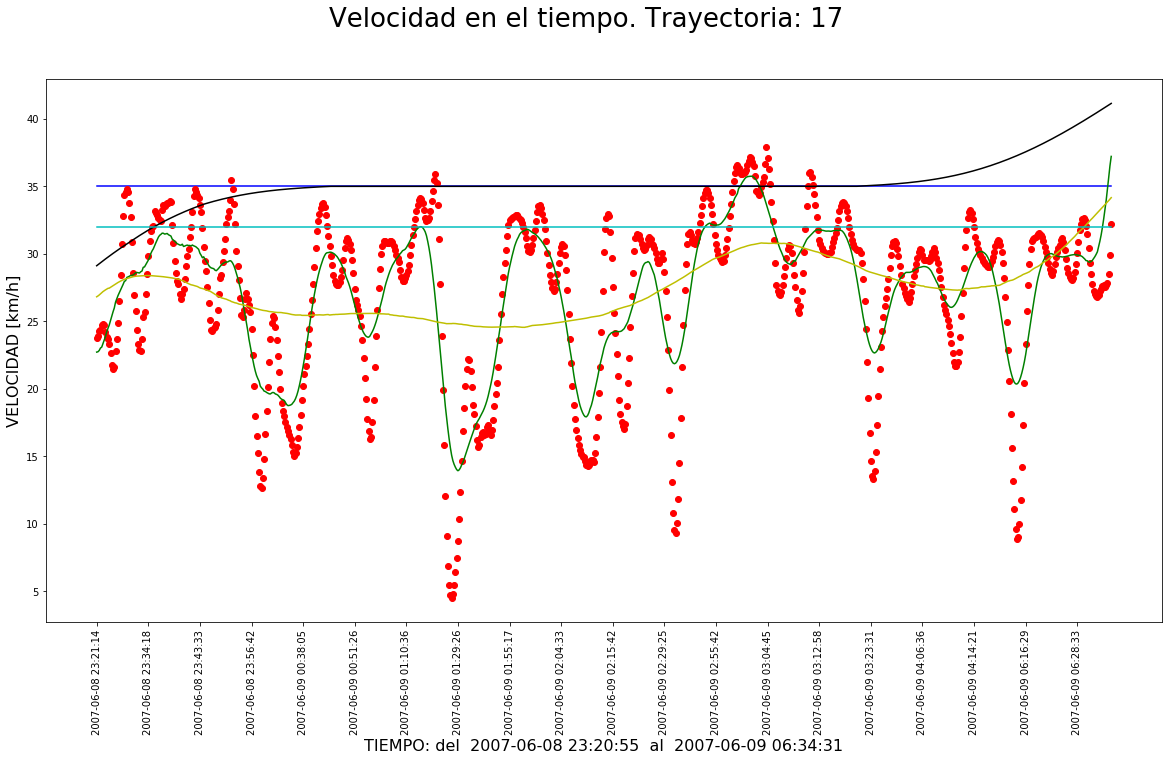

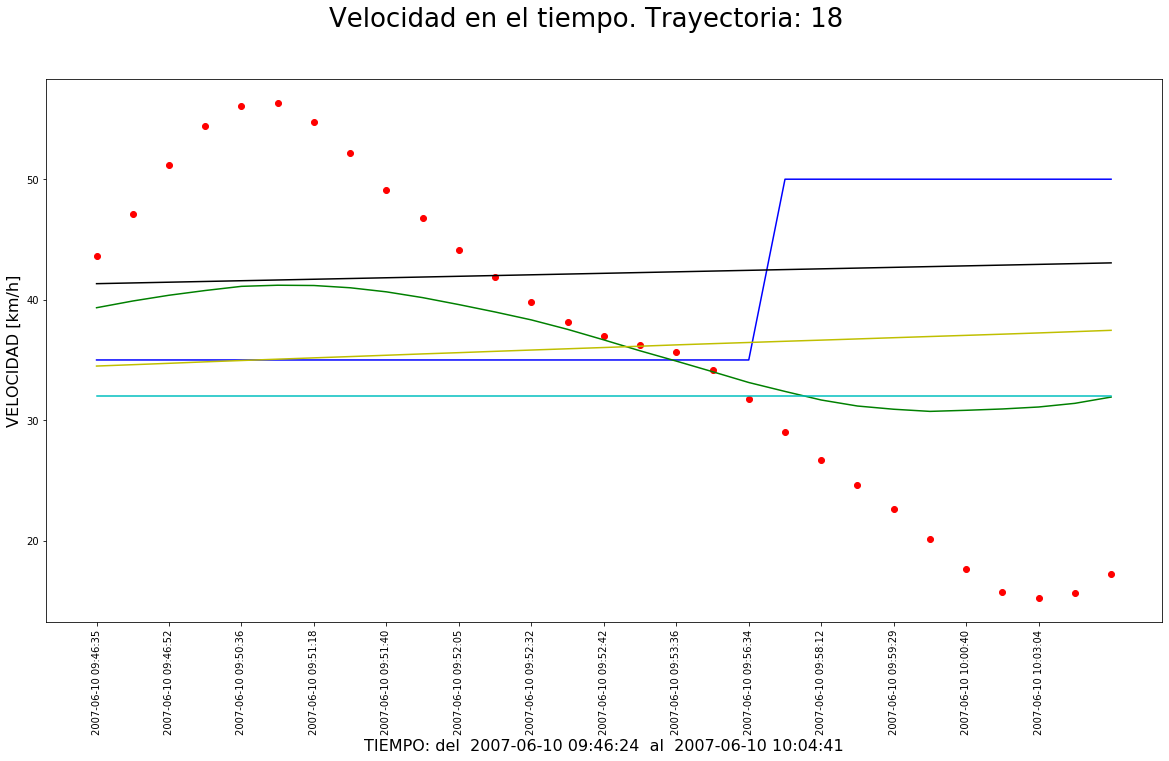

In [374]:

for trayectoria,rangodt in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) if (idx>9 and idx<19)] : #if idx<24
    s_str=df.loc[rangodt[0],'time']
    e_str=df.loc[rangodt[1],'time']
    print(s_str," <--> ",e_str)
    plot_evolucion_vel(df,s_str,e_str, vel='velprep2' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")


In [383]:
df = pd.read_pickle("geolife_111_features.zip")

2008/06/27 00:06:06  <-->  2008/06/27 02:06:26
range(186654, 186721, 4)
186654 186721


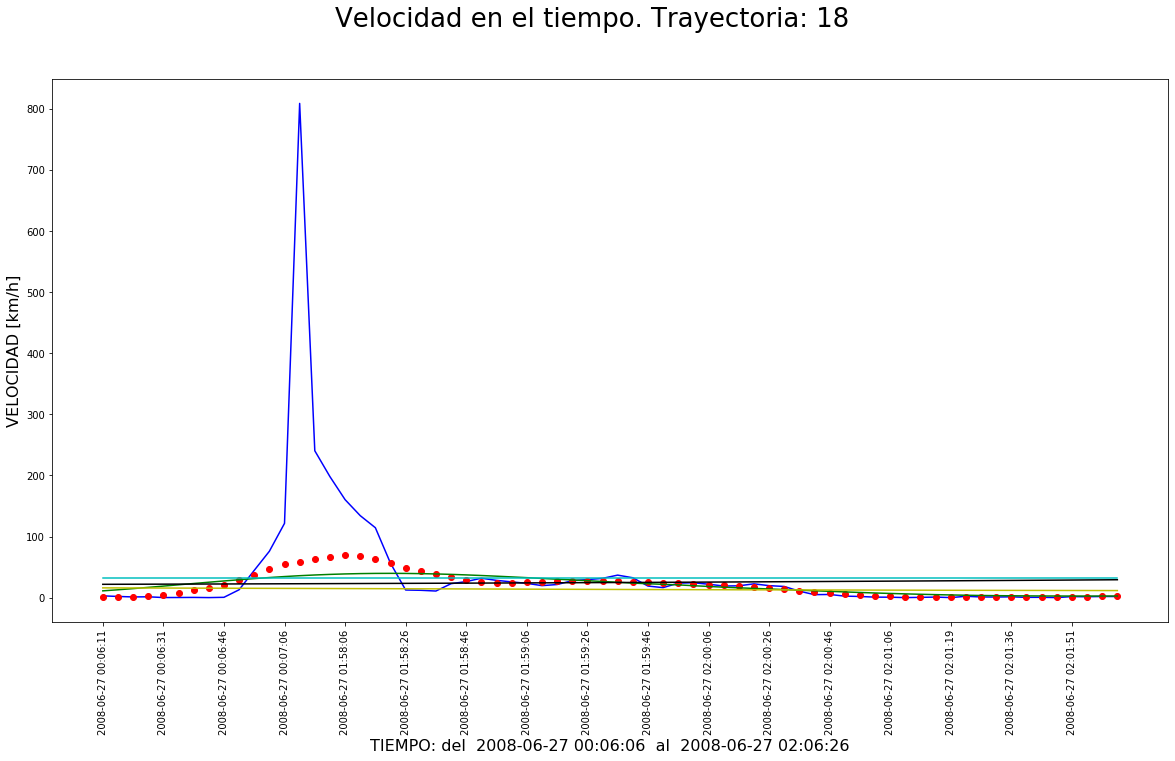

In [411]:
#s_str=df.loc[start_ix[1],'time']
#e_str=df.loc[end_ix[1],'time']
#2007/09/05 00:20:00	2007/09/05 05:17:00	airplane
#2008/06/26 23:40:00	2008/06/27 01:58:26	airplane
s_str="2008/06/27 00:06:06"
e_str="2008/06/27 02:06:26"
print(s_str," <--> ",e_str)
#df['velprep2']=df.velMA3.apply(lambda x : 5+(20*np.round((x-5)/20)))
#df['velprep2']=df.velMA3.apply(lambda x : 5+(5*np.round((x-15)/15) if ( x < 20 ) else 5+(40*np.round((x-5)/40) )) )
plot_evolucion_vel(df,s_str,e_str, vel='vel' , tit=f"Velocidad en el tiempo. Trayectoria: {trayectoria}")

In [67]:
for a,b in [ (idx, x) for idx,x in enumerate(zip(start_ix,end_ix)) if idx<6]:
    print(a,b)

0 (0, 86)
1 (87, 352)
2 (353, 507)
3 (508, 621)
4 (622, 1463)
5 (1464, 13304)


In [1001]:
rangotiks=df.velMA.nlargest(20).index.values.tolist()
rangotiks.extend(df.velMA.nsmallest(20).index.values.tolist())

rangotiks

[865,
 866,
 867,
 868,
 864,
 869,
 1090,
 1091,
 863,
 1089,
 1092,
 1093,
 870,
 1088,
 1094,
 862,
 1095,
 1087,
 1096,
 871,
 403,
 402,
 404,
 263,
 264,
 1233,
 1232,
 262,
 401,
 326,
 1234,
 1231,
 405,
 374,
 376,
 375,
 242,
 325,
 377,
 265]

In [116]:
dft=df.loc[(df.time > parsedt('2008-05-09 08:13:55')) & (df.time < parsedt('2008-05-12 08:13:55'))]
dft.loc[ dft.index.isin([1,3,4,5,6,7,8,9,10,11]) , 'time']

3    2008-05-09 08:15:45
4    2008-05-09 10:08:06
5    2008-05-09 10:08:16
6    2008-05-09 10:08:37
7    2008-05-09 10:09:16
8    2008-05-09 10:09:32
9    2008-05-09 10:09:39
10   2008-05-09 10:09:49
11   2008-05-09 10:09:58
Name: time, dtype: datetime64[ns]

In [106]:
dft.index,dft.index[len(dft)-1]

Int64Index([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
            ...
            612, 613, 614, 615, 616, 617, 618, 619, 620, 621],
           dtype='int64', length=619)

In [ ]:
dft.

In [1011]:
df.vel.nlargest(100).mean()

96.50730000000007

In [245]:
df2 = df.copy()
df2.loc[df2.label==0]

,time,lat,lon,alt,label,user,idx_traj,vel,velMA,velprep,velMA2,velMA3,velprep2
0,2009-09-23 09:20:00,39.974755,116.335742,491.818707,0,123,0,5.15,5.450000,5.15,6.859375,37.241085,36.0
1,2009-09-23 09:20:05,39.974720,116.335688,490.554049,0,123,1,5.15,5.360465,5.15,7.276932,37.899574,36.0
2,2009-09-23 09:20:10,39.974635,116.335778,489.346312,0,123,2,9.91,5.267143,9.91,7.743316,38.559127,36.0
3,2009-09-23 09:20:15,39.974608,116.335765,487.443570,0,123,3,2.40,5.041481,2.40,8.272315,39.217296,36.0
4,2009-09-23 09:20:20,39.974598,116.335760,485.694715,0,123,4,0.89,4.923621,0.89,8.930630,39.878236,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8823,2009-09-27 16:11:33,34.225602,108.950589,1298.741519,0,123,1549,3.22,2.236207,3.22,2.670599,5.759862,4.0
8824,2009-09-27 16:11:38,34.225649,108.950592,1298.040656,0,123,1550,3.77,2.216481,3.77,2.652869,5.620463,4.0
8825,2009-09-27 16:12:03,34.225909,108.950594,1299.456099,0,123,1551,4.16,2.153265,4.16,2.632488,5.488253,4.0
8826,2009-09-27 16:12:08,34.225892,108.950590,1298.675436,0,123,1552,1.40,2.075349,1.40,2.607498,5.379631,4.0


In [135]:

mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
mode_marker_dict = {i + 1:s for i, s in enumerate(mode_marker)}
mode_color_dict = {i + 1:s for i, s in enumerate(mode_color)}
print(mode_marker,mode_color)

['pitch', 'bicycle', 'bus', 'car', 'rail-underground', 'rail', 'airport', 'ferry', 'pitch', 'scooter', 'car'] ['#f16f04', '#1ac16b', '#68aa31', '#8043b1', '#29c6db', '#470e53', '#595454', '#2026d5', '#f16f04', '#e52315', '#f6fa00']


In [155]:
df.drop(columns=['alt','label','user'],inplace=True)
df['marker-size']='large'
df['marker-color']=df.label.apply(lambda x: mode_color[x]  if x > 0 else "#454545" )
df['marker-symbol']="square"

AttributeError: 'DataFrame' object has no attribute 'label'

In [153]:
mode_color[x] if x > 0 else 0

'#e52315'

In [154]:
x = 0

In [682]:
del(gdf)
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))
gdf.drop(columns=['lat','lon'],inplace=True)
gdf

,time,alt,label,user,vel,velr,geometry
0,2007-10-19 05:23:15,482.283465,11,175,5.113602,5,POINT (116.33060 39.97512)
1,2007-10-19 05:24:15,482.283465,11,175,5.113602,5,POINT (116.32983 39.97510)
2,2007-10-19 05:25:29,157.480315,11,175,8.628732,10,POINT (116.32825 39.97530)
3,2007-10-19 05:27:53,111.548556,11,175,24.182711,25,POINT (116.31955 39.97505)
4,2007-10-19 05:28:51,203.412073,11,175,47.026808,45,POINT (116.31273 39.97497)
...,...,...,...,...,...,...,...
303,2007-10-22 01:48:25,104.986877,3,175,8.299702,10,POINT (116.31565 39.96592)
304,2007-10-22 01:49:25,104.986877,3,175,4.149520,5,POINT (116.31587 39.96650)
305,2007-10-22 01:49:46,124.671916,3,175,23.304061,25,POINT (116.31472 39.96692)
306,2007-10-22 01:51:19,216.535433,3,175,4.886835,5,POINT (116.31428 39.96797)


In [686]:
gdf.loc[:,gdf.columns!='geometry']

,time,alt,label,user,vel,velr
0,2007-10-19 05:23:15,482.283465,11,175,5.113602,5
1,2007-10-19 05:24:15,482.283465,11,175,5.113602,5
2,2007-10-19 05:25:29,157.480315,11,175,8.628732,10
3,2007-10-19 05:27:53,111.548556,11,175,24.182711,25
4,2007-10-19 05:28:51,203.412073,11,175,47.026808,45
...,...,...,...,...,...,...
303,2007-10-22 01:48:25,104.986877,3,175,8.299702,10
304,2007-10-22 01:49:25,104.986877,3,175,4.149520,5
305,2007-10-22 01:49:46,124.671916,3,175,23.304061,25
306,2007-10-22 01:51:19,216.535433,3,175,4.886835,5


In [689]:
gdf.time=gdf.time.astype(str)
gdf.dtypes

time          object
alt          float64
label          int64
user           int64
vel          float64
velr           int64
geometry    geometry
dtype: object

In [691]:
gdf.loc[300,'vel']

0.48469027625997424

In [87]:
gdf.to_file("geolife_170_.geojson", driver="GeoJSON")

,time,lat,lon,alt,label,user,idx_traj,vel,velMA,velprep,velMA2,velMA3,velprep2,prueba,pruebas,velprep3
0,2009-09-23 09:20:00,39.974755,116.335742,491.818707,0,123,0,5.15,5.450000,5.15,6.859375,55.558637,65.0,71.568723,73.373318,62.0
1,2009-09-23 09:20:05,39.974720,116.335688,490.554049,0,123,1,5.15,5.360465,5.15,7.276932,55.870621,65.0,71.643884,73.362371,62.0
2,2009-09-23 09:20:10,39.974635,116.335778,489.346312,0,123,2,9.91,5.267143,9.91,7.743316,56.182925,65.0,71.719030,73.351070,62.0
3,2009-09-23 09:20:15,39.974608,116.335765,487.443570,0,123,3,2.40,5.041481,2.40,8.272315,56.498092,65.0,71.794158,73.339405,62.0
4,2009-09-23 09:20:20,39.974598,116.335760,485.694715,0,123,4,0.89,4.923621,0.89,8.930630,56.813360,65.0,71.869264,73.327369,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8823,2009-09-27 16:11:33,34.225602,108.950589,1298.741519,0,123,1549,3.22,2.236207,3.22,2.670599,10.232110,20.0,20.000000,20.000000,32.0
8824,2009-09-27 16:11:38,34.225649,108.950592,1298.040656,0,123,1550,3.77,2.216481,3.77,2.652869,10.142368,20.0,20.000000,20.000000,32.0
8825,2009-09-27 16:12:03,34.225909,108.950594,1299.456099,0,123,1551,4.16,2.153265,4.16,2.632488,10.052521,20.0,20.000000,20.000000,32.0
8826,2009-09-27 16:12:08,34.225892,108.950590,1298.675436,0,123,1552,1.40,2.075349,1.40,2.607498,9.958023,20.0,20.000000,20.000000,32.0


In [408]:

import geojsonio

In [412]:
ruta='''
{"features": [{"geometry": {"coordinates": [116.3318, 39.976], "type": "Point"}, "properties": {"date": "2010-03-12 17:26:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3316, 39.9769], "type": "Point"}, "properties": {"date": "2010-03-12 17:27:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:28:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.332, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:29:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9774], "type": "Point"}, "properties": {"date": "2010-03-12 17:30:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3322, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:31:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9775], "type": "Point"}, "properties": {"date": "2010-03-12 17:32:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3313, 39.9781], "type": "Point"}, "properties": {"date": "2010-03-12 17:33:00"}, "type": "Feature"}], "type": "FeatureCollection"}
''' 

print(ruta)
geojsonio.display(ruta)


{"features": [{"geometry": {"coordinates": [116.3318, 39.976], "type": "Point"}, "properties": {"date": "2010-03-12 17:26:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3316, 39.9769], "type": "Point"}, "properties": {"date": "2010-03-12 17:27:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:28:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.332, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:29:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9774], "type": "Point"}, "properties": {"date": "2010-03-12 17:30:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3322, 39.9776], "type": "Point"}, "properties": {"date": "2010-03-12 17:31:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3319, 39.9775], "type": "Point"}, "properties": {"date": "2010-03-12 17:32:00"}, "type": "Feature"}, {"geometry": {"coordinates": [116.3313, 39

'http://geojson.io/#data=data:application/json,%0A%7B%22features%22%3A%20%5B%7B%22geometry%22%3A%20%7B%22coordinates%22%3A%20%5B116.3318%2C%2039.976%5D%2C%20%22type%22%3A%20%22Point%22%7D%2C%20%22properties%22%3A%20%7B%22date%22%3A%20%222010-03-12%2017%3A26%3A00%22%7D%2C%20%22type%22%3A%20%22Feature%22%7D%2C%20%7B%22geometry%22%3A%20%7B%22coordinates%22%3A%20%5B116.3316%2C%2039.9769%5D%2C%20%22type%22%3A%20%22Point%22%7D%2C%20%22properties%22%3A%20%7B%22date%22%3A%20%222010-03-12%2017%3A27%3A00%22%7D%2C%20%22type%22%3A%20%22Feature%22%7D%2C%20%7B%22geometry%22%3A%20%7B%22coordinates%22%3A%20%5B116.3319%2C%2039.9776%5D%2C%20%22type%22%3A%20%22Point%22%7D%2C%20%22properties%22%3A%20%7B%22date%22%3A%20%222010-03-12%2017%3A28%3A00%22%7D%2C%20%22type%22%3A%20%22Feature%22%7D%2C%20%7B%22geometry%22%3A%20%7B%22coordinates%22%3A%20%5B116.332%2C%2039.9776%5D%2C%20%22type%22%3A%20%22Point%22%7D%2C%20%22properties%22%3A%20%7B%22date%22%3A%20%222010-03-12%2017%3A29%3A00%22%7D%2C%20%22type%22%3A%20

In [178]:
ls=LineString(gdf.geometry.iloc[10:100].to_list())
gdf.geometry.iloc[0]=ls

In [449]:
print(LineString(gdf.geometry.iloc[10:20].to_list()).wkt)

LINESTRING (116.333778 39.975414, 116.333809 39.975396, 116.333833 39.975382, 116.33385 39.97537, 116.333876 39.975369, 116.333901 39.97538, 116.33392 39.975379, 116.333938 39.97538400000001, 116.33394 39.975408, 116.333942 39.975421)


In [ ]:
geopandas.geodataframe.to_json

In [179]:
gdf

,date,label,geometry
0,2008-10-24T04:12:00,0,"LINESTRING (116.32675 39.99713, 116.32668 39.9..."
1,2008-10-24T04:13:00,0,POINT (116.32148 40.00351)
2,2008-10-24T04:14:00,0,POINT (116.32151 40.00173)
3,2008-10-24T04:15:00,0,POINT (116.32173 39.99988)
4,2008-10-24T04:16:00,0,POINT (116.32378 39.99957)
...,...,...,...
8757,2009-03-19T05:42:00,0,POINT (116.32462 40.00111)
8758,2009-03-19T05:43:00,0,POINT (116.32560 40.00109)
8759,2009-03-19T05:44:00,0,POINT (116.32645 40.00114)
8760,2009-03-19T05:45:00,0,POINT (116.32707 40.00102)


In [433]:
dfxb = geopandas.read_file("map.geojson")
dfxb.w

,marker-color,marker-size,marker-symbol,stroke,stroke-width,stroke-opacity,fill,fill-opacity,geometry
0,#d77070,small,square,None,NaN,NaN,None,NaN,POINT (84.26239 42.79540)
1,None,None,None,#e7dada,2.0,1.0,#ffffff,0.0,"POLYGON ((84.35303 42.86590, 84.33380 42.75710..."
2,None,None,None,None,NaN,NaN,None,NaN,"LINESTRING (84.56039 42.77323, 84.50684 42.899..."


In [421]:

from geopy.distance import distance
distance(p1, p2)
Out: Distance(229.883275249)
distance(p1, p2).km
Out: 229.88327524944066

NameError: name 'p1' is not defined